In [121]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem import MeshLine, ElementLineP1, Basis, BilinearForm, LinearForm
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.stats as scstats
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

import pytensor.tensor.subtensor as subtensor
import pytensor.tensor as tensor
import arviz as az

In [122]:
import scienceplots
# plot params
contour_levels = 20
plt.style.use(['science', 'grid'])
color_list = [(253, 231, 37),(194, 223, 35),(134, 213, 73),(82, 197, 105),(42, 176, 127),(30, 155, 138),(37, 133, 142),(45, 112, 142),(56, 88, 140),(67, 62, 133),(72, 33, 115),(68, 1, 84)]
color_list = [tuple(ti/255 for ti in t) for t in color_list]

/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


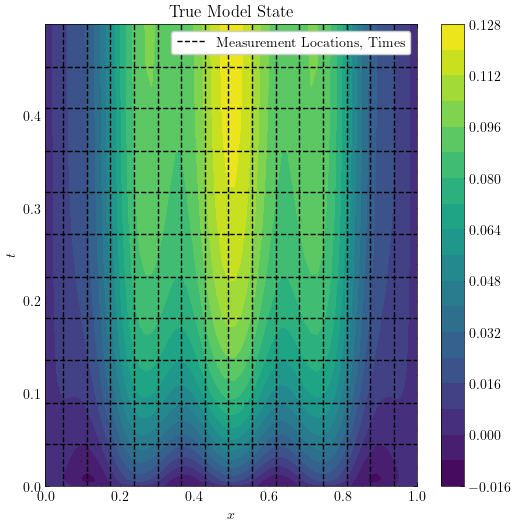

In [3]:
class PredictiveModel:
    """
    A class to represent and solve a predictive model using FEM and MCMC methods.

    Attributes:
        nx_cells (int): Number of axial cells in the spatial discretization.
        x_left (float): Left boundary of the spatial domain.
        x_right (float): Right boundary of the spatial domain.
        t_start (float): Start time for the simulation.
        dt (float): Time step size.
        t_end (float): End time for the simulation.
        spatial_points (int): Number of spatial measurement points.
        temporal_points (int): Number of temporal measurement points.
        x_s (numpy.ndarray): Array of spatial discretization points.
        mesh (fem.MeshLine): FEM mesh object.
        element (fem.ElementLineP1): FEM element object.
        basis (fem.Basis): FEM basis object.
        coords (numpy.ndarray): True spatial coordinates.
        n_x (int): Number of spatial points.
        boundary_condition (numpy.ndarray): Boolean array for boundary conditions.
        boundary_indices (numpy.ndarray): Indices of boundary points.
        time_range (numpy.ndarray): Array of time steps.
        n_steps (int): Number of time steps.
        u_0true (numpy.ndarray): Initial true state.
        u_strue (numpy.ndarray): Array to store true states over time.
        spatial_points (int): Number of spatial measurement points.
        temporal_points (int): Number of temporal measurement points.
        spatial_measurement_indices (numpy.ndarray): Indices for spatial measurements.
        spatial_measurement_coords (numpy.ndarray): Coordinates of spatial measurement points.
        temporal_measurement_indices (numpy.ndarray): Indices for temporal measurements.
        temporal_measurement_coords (numpy.ndarray): Coordinates of temporal measurement points.
    """

    def __init__(self, nx_cells=64, x_left=0., x_right=1., t_start=0, dt=0.001, t_end=0.5, spatial_points=15, temporal_points=10):
        """
        Initializes the PredictiveModel with the given parameters.

        Parameters:
            nx_cells (int): Number of axial cells in the spatial discretization.
            x_left (float): Left boundary of the spatial domain.
            x_right (float): Right boundary of the spatial domain.
            t_start (float): Start time for the simulation.
            dt (float): Time step size.
            t_end (float): End time for the simulation.
            spatial_points (int): Number of spatial measurement points.
            temporal_points (int): Number of temporal measurement points.
        """
        # Spatial discretization parameters
        self.nx_cells = nx_cells
        self.x_left = x_left
        self.x_right = x_right

        # Create the mesh for spatial discretization
        self.x_s = np.linspace(self.x_left, self.x_right, self.nx_cells)
        self.mesh = MeshLine(self.x_s)
        self.element = ElementLineP1()
        self.basis = Basis(self.mesh, self.element)

        # Extract coordinates and boundary indices
        self.coords = self.mesh.p.T
        self.n_x = len(self.coords)
        self.boundary_condition = (self.coords == self.x_left) | (self.coords == self.x_right)
        self.boundary_indices = np.where(self.boundary_condition)[0]

        # Time parameters
        self.t_start = t_start
        self.dt = dt
        self.t_end = t_end
        self.time_range = np.arange(self.t_start, self.t_end, self.dt)
        self.n_steps = len(self.time_range)

        # Initialize state arrays
        self.u_0true = np.zeros(self.n_x)
        self.u_strue = np.zeros((self.n_steps, self.n_x))
        self.u_strue[0, :] = self.u_0true

        # Observation parameters
        self.spatial_points = spatial_points
        self.temporal_points = temporal_points

        # Determine measurement indices and coordinates
        temp_spatial = np.linspace(0, len(self.coords) - 1, self.spatial_points + 2, dtype=int)
        self.spatial_measurement_indices = temp_spatial[1:-1]
        self.spatial_measurement_coords = self.coords[self.spatial_measurement_indices]

        temp_temporal = np.linspace(0, len(self.time_range) - 1, self.temporal_points + 2, dtype=int)
        self.temporal_measurement_indices = temp_temporal[1:-1]
        self.temporal_measurement_coords = self.time_range[self.temporal_measurement_indices]

    def solve_and_observe(self, true_alpha=1, true_beta=1, sigma_n_true=0.005):
        """
        Solves the predictive model and generates observed data with noise.

        Parameters:
            true_alpha (float): Coefficient for the bilinear form `b`.
            true_beta (float): Source term coefficient for the linear form `l`.
            sigma_n_true (float): Standard deviation of the Gaussian noise added to observations.
        """
        # Define bilinear and linear forms
        @BilinearForm
        def a(u, v, w):
            """Bilinear form a(u, v)."""
            return u * v

        @BilinearForm
        def b(u, v, w):
            """Bilinear form b(u, v) with true_alpha."""
            return true_alpha * dot(grad(u), grad(v))

        @LinearForm
        def l(v, w):
            """Linear form l(v) with true_beta."""
            x = w.x
            f = 8 * np.cos(np.pi * 8 * x[0]) + true_beta
            return f * v

        # Assemble matrices and vectors
        A_mat = a.assemble(self.basis)
        B_mat = b.assemble(self.basis)
        L_vec = l.assemble(self.basis)

        # Boundary function (zero boundary condition)
        def boundary_function(boundary_coords):
            """Boundary condition function."""
            return 0.

        # Precompute the inverse of the operator
        pre_OP1 = A_mat + self.dt * B_mat
        pre_OP1[self.boundary_indices, :] = pre_OP1[:, self.boundary_indices] = 0.
        pre_OP1[self.boundary_indices, self.boundary_indices] = 1.
        OP1 = scsparse.linalg.inv(pre_OP1)

        # Time-stepping solution
        for i, t in enumerate(self.time_range[:-1]):
            OP2 = self.dt * L_vec + A_mat @ self.u_strue[i, :]
            OP2[self.boundary_indices] = boundary_function(self.coords[self.boundary_indices])
            self.u_strue[i + 1, :] = OP1 @ OP2

        # Add noise to the observed data
        self.u_observed = self.u_strue[self.temporal_measurement_indices][:, self.spatial_measurement_indices] + \
                          np.random.normal(0, sigma_n_true, (self.temporal_points, self.spatial_points))

    def plot(self, contour_levels=20):
        """
        Plots the true model state with measurement locations and times.

        Parameters:
            contour_levels (int): Number of contour levels to display in the plot.
        """
        fig, axes = plt.subplots(figsize=(6, 6))
        plot = axes.contourf(self.coords.flatten(), self.time_range, self.u_strue, levels=contour_levels)
        
        # Plot spatial measurement lines
        for num, coord in enumerate(self.spatial_measurement_coords.flatten()):
            if num == 0:
                axes.axvline(coord, linestyle='--', label='Measurement Locations, Times', color='black')
            else:
                axes.axvline(coord, linestyle='--', color='black')
        
        # Plot temporal measurement lines
        for num, coord in enumerate(self.temporal_measurement_coords.flatten()):
            axes.axhline(coord, linestyle='--', color='black')
        
        # Plot observed points
        x_temp, y_temp = np.meshgrid(self.coords[self.spatial_measurement_indices].flatten(), self.time_range[self.temporal_measurement_indices].flatten())
        x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

        axes.set_xlabel(r'$x$')
        axes.set_ylabel(r'$t$')
        axes.set_title('True Model State')
        fig.colorbar(plot)
        plt.legend()
        plt.show()

predictive_model = PredictiveModel(
    nx_cells = 64,
    spatial_points = 15,
    temporal_points = 10
)
predictive_model.solve_and_observe(
    true_alpha = 1,
    true_beta = 1,
    sigma_n_true = 0.005
)
predictive_model.plot(
    contour_levels = 20
)

In [4]:
class PredictiveModel:
    def __init__(self, number_of_x_axial_cells=64, x_axis_left_boundary=0., x_axis_right_boundary=1., 
                 t_start=0, dt=0.001, t_end=0.5, spatial_measurement_coordinates=None, 
                 temporal_measurement_coordinates=None, u_observed=None):
        """
        Initialize the PredictiveModel with grid and measurement parameters.

        Parameters:
        - number_of_x_axial_cells: Number of cells in the x-axis.
        - x_axis_left_boundary: Left boundary of the x-axis.
        - x_axis_right_boundary: Right boundary of the x-axis.
        - t_start: Start time of the simulation.
        - dt: Time step size.
        - t_end: End time of the simulation.
        - spatial_measurement_coordinates: Coordinates where spatial measurements are taken.
        - temporal_measurement_coordinates: Time points where measurements are taken.
        - u_observed: Observed data at measurement points.
        """
        # Grid parameters
        self.x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)
        self.mesh = fem.MeshLine(self.x_s)
        self.element = fem.ElementLineP1()
        self.basis = fem.Basis(self.mesh, self.element)
        
        # Coordinates and boundary conditions
        self.coordinates = self.mesh.p.T
        self.n_x = len(self.coordinates)
        self.boundary_condition = (
            (self.coordinates == x_axis_left_boundary) | (self.coordinates == x_axis_right_boundary)
        )
        self.boundary_indices = np.where(self.boundary_condition)[0]
        
        # Time parameters
        self.time_range = np.arange(t_start, t_end, dt)
        self.n_steps = len(self.time_range)
        
        # Initial conditions
        self.u_0 = np.zeros(self.n_x)
        self.u_s = np.zeros((self.n_steps, self.n_x))
        self.u_s[0, :] = self.u_0
        
        # Measurement parameters
        self.spatial_measurement_coordinates = spatial_measurement_coordinates
        self.temporal_measurement_coordinates = temporal_measurement_coordinates
        self.u_observed = u_observed
        
        # Observation operator
        self.observation_operator = np.zeros((len(self.spatial_measurement_coordinates), len(self.coordinates)))
        for i, y in enumerate(self.spatial_measurement_coordinates):
            nearest_index = np.argmin(np.abs(self.coordinates - y))
            self.observation_operator[i, nearest_index] = 1
        
        self.time_operator = self.mark_times(self.time_range, self.temporal_measurement_coordinates)
        
        # Precomputed matrices
        self.K_theta_1 = np.tile(self.coordinates, ((self.n_x, 1)))
        self.K_theta_2 = np.repeat(self.coordinates, (self.n_x), axis=0)
        self.K_theta_3 = -np.linalg.norm(self.K_theta_1 - self.K_theta_2, axis=1)
        self.K_theta_3_np = -np.linalg.norm(self.K_theta_1 - self.K_theta_2, axis=1)
        
        self.M_mat = (self.M_form().toarray())
        self.L_vec = self.L_form().assemble(self.basis)
        self.A_mat = (self.A_form().assemble(self.basis)).toarray()
        
        # Initialize parameters
        self.alpha_params = [0.0001, 3., 1.5, 0.5]
        self.beta_params = [0.0001, 3., 0.5, 0.5]
        self.rho_params = [0.0001, 1., 0.1, 0.1]
        self.ell_params = [0.0001, 3., 0.1, 0.1]
        self.sigma_n_params = [0.0001, 1., 0.005, 0.005]
        
        self.traces = []  # Box of traces
        self.priors = []  # Box of KDEs
        self.data_index = 0  # Index of observation vector
        self.covs = []

    def M_form(self):
        """
        Define the mass matrix bilinear form.

        Returns:
        - M: Mass matrix as a bilinear form.
        """
        @fem.BilinearForm
        def M(u, v, w):
            return u * v
        return M.assemble(self.basis).toarray()

    def A_form(self):
        """
        Define the stiffness matrix bilinear form.

        Returns:
        - A: Stiffness matrix as a bilinear form.
        """
        @fem.BilinearForm
        def A(u, v, w):
            return dot(grad(u), grad(v))
        return A.assemble(self.basis).toarray()

    def L_form(self):
        """
        Define the load vector linear form.

        Returns:
        - L: Load vector as a linear form.
        """
        @fem.LinearForm
        def L(v, w):
            return 1. * v
        return L.assemble(self.basis)

    def mark_times(self, all_time, mark_time):
        """
        Mark the times in the given range that match the observation times.

        Parameters:
        - all_time: Full range of time values.
        - mark_time: Specific times to mark.

        Returns:
        - time_operator: Boolean array marking the observation times.
        """
        time_operator = np.zeros_like(all_time, dtype=bool)
        for time in mark_time:
            closest_index = np.argmin(np.abs(all_time - time))
            time_operator[closest_index] = True
        return time_operator

    def left_side(self, alpha):
        """
        Compute the left-hand side matrix for the system update.

        Parameters:
        - alpha: Parameter value for the update.

        Returns:
        - left_mat: Updated left-hand side matrix.
        """
        left_mat = (self.M_mat + (self.dt * alpha / 2) * self.A_mat)
        left_mat = subtensor.set_subtensor(left_mat[0, :], 0.)
        left_mat = subtensor.set_subtensor(left_mat[-1, :], 0.)
        left_mat = subtensor.set_subtensor(left_mat[0, 0], 1.)
        left_mat = subtensor.set_subtensor(left_mat[-1, -1], 1.)
        return left_mat

    def left_side_np(self, alpha):
        """
        Compute the left-hand side matrix using numpy.

        Parameters:
        - alpha: Parameter value for the update.

        Returns:
        - left_mat: Updated left-hand side matrix.
        """
        left_mat = (self.M_mat + (self.dt * alpha / 2) * self.A_mat)
        left_mat[self.boundary_indices, :] = left_mat[:, self.boundary_indices] = 0.
        left_mat[self.boundary_indices, self.boundary_indices] = 1.
        return left_mat

    def right_side(self, alpha, beta, u_prev):
        """
        Compute the right-hand side vector for the system update.

        Parameters:
        - alpha: Parameter value for the update.
        - beta: Another parameter for the update.
        - u_prev: Previous state vector.

        Returns:
        - right_mat: Right-hand side vector.
        """
        right_mat = (self.M_mat - (self.dt * alpha / 2) * self.A_mat) @ u_prev + self.dt * beta * self.L_vec
        right_mat = subtensor.set_subtensor(right_mat[0], 0.)
        right_mat = subtensor.set_subtensor(right_mat[-1], 0.)
        return right_mat

    def G_theta_mat(self, rho, ell):
        """
        Compute the covariance matrix based on given parameters.

        Parameters:
        - rho: Parameter for covariance calculation.
        - ell: Parameter for covariance calculation.

        Returns:
        - G_theta: Covariance matrix.
        """
        G_vec = (rho ** 2) * tensor.math.exp(self.K_theta_3 / (2 * (ell ** 2)))
        return tensor.reshape(G_vec, (self.n_x, self.n_x))

    def G_theta_mat_np(self, rho, ell):
        """
        Compute the covariance matrix based on given parameters using numpy.

        Parameters:
        - rho: Parameter for covariance calculation.
        - ell: Parameter for covariance calculation.

        Returns:
        - G_theta: Covariance matrix.
        """
        G_vec = (rho ** 2) * np.exp(self.K_theta_3_np / (2 * (ell ** 2)))
        return np.reshape(G_vec, (self.n_x, self.n_x))

    def solve_and_update(self):
        """
        Solve the predictive model using Kalman filter and MCMC updates.
        """
        alpha = self.alpha_params[2]
        beta = self.beta_params[2]
        rho = self.rho_params[2]
        ell = self.ell_params[2]
        sigma_n = self.sigma_n_params[2]

        for i, t in tqdm(enumerate(self.time_range[:-1])):
            if i == 0:
                right_hand_side = (self.M_mat - (self.dt * alpha / 2) * self.A_mat) @ self.u_s[i, :] + self.dt * beta * self.L_vec
                right_hand_side[0] = right_hand_side[-1] = 0.
                pred_mean = np.linalg.inv(self.left_side_np(alpha)) @ right_hand_side
                pred_cov = self.dt * np.linalg.inv(self.left_side_np(alpha)) @ self.M_mat @ self.G_theta_mat_np(rho, ell) @ self.M_mat.T @ np.linalg.inv(self.left_side_np(alpha)).T
                self.u_s[i + 1, :] = pred_mean
                self.covs.append(pred_cov)
            else:
                if not self.time_operator[i]:
                    right_hand_side = (self.M_mat - (self.dt * alpha / 2) * self.A_mat) @ self.u_s[i, :] + self.dt * beta * self.L_vec
                    right_hand_side[0] = right_hand_side[-1] = 0.
                    pred_mean = np.linalg.inv(self.left_side_np(alpha)) @ right_hand_side
                    self.u_s[i + 1, :] = pred_mean
                    self.covs.append(self.covs[-1])
                else:
                    with pm.Model() as model:
                        if self.data_index == 0:
                            alpha = pm.TruncatedNormal('alpha', mu=self.alpha_params[2], sigma=self.alpha_params[3], lower=self.alpha_params[0], upper=self.alpha_params[1])
                            beta = pm.TruncatedNormal('beta', mu=self.beta_params[2], sigma=self.beta_params[3], lower=self.beta_params[0], upper=self.beta_params[1])
                            rho = pm.TruncatedNormal('rho', mu=self.rho_params[2], sigma=self.rho_params[3], lower=self.rho_params[0], upper=self.rho_params[1])
                            ell = pm.TruncatedNormal('ell', mu=self.ell_params[2], sigma=self.ell_params[3], lower=self.ell_params[0], upper=self.ell_params[1])
                            sigma_n = pm.TruncatedNormal('sigma_n', mu=self.sigma_n_params[2], sigma=self.sigma_n_params[3], lower=self.sigma_n_params[0], upper=self.sigma_n_params[1])
                        else:
                            alpha = pm.TruncatedNormal('alpha', mu=alpha, sigma=self.alpha_params[3], lower=self.alpha_params[0], upper=self.alpha_params[1])
                            beta = pm.TruncatedNormal('beta', mu=beta, sigma=self.beta_params[3], lower=self.beta_params[0], upper=self.beta_params[1])
                            rho = pm.TruncatedNormal('rho', mu=rho, sigma=self.rho_params[3], lower=self.rho_params[0], upper=self.rho_params[1])
                            ell = pm.TruncatedNormal('ell', mu=ell, sigma=self.ell_params[3], lower=self.ell_params[0], upper=self.ell_params[1])
                            sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n, sigma=self.sigma_n_params[3], lower=self.sigma_n_params[0], upper=self.sigma_n_params[1])

                        left_side_matrix = pm.Deterministic('left_side', self.left_side(alpha))
                        G_rho_ell = pm.Deterministic('G_rho_ell', self.M_mat @ self.G_theta_mat(rho, ell) @ self.M_mat.T)

                        left_side_inv = tensor.nlinalg.matrix_inverse(left_side_matrix)
                        right_side_vector = pm.Deterministic('right_side', self.right_side(alpha, beta, self.u_s[i, :]))
                        mu_u = pm.Deterministic('mu_u', left_side_inv @ right_side_vector)
                        cov_u = pm.Deterministic('cov_u', (left_side_inv @ (self.M_mat - (self.dt * alpha / 2) * self.A_mat)) @ self.covs[-1] @ (left_side_inv @ (self.M_mat - (self.dt * alpha / 2) * self.A_mat)).T + self.dt * left_side_inv @ G_rho_ell @ left_side_inv.T)

                        cov_chol = tensor.linalg.cholesky(self.observation_operator @ cov_u @ self.observation_operator.T + sigma_n ** 2 * np.eye(self.observation_operator.shape[0]))
                        y_obs = pm.MvNormal('y_obs', mu=self.observation_operator @ mu_u, chol=cov_chol, observed=self.u_observed[self.data_index, :])
                        trace = pm.sample(nuts_sampler="numpyro", chains=2, target_accept=0.95)
                        self.traces.append(trace)

                    # Update parameters to means of their posteriors
                    alpha = np.mean(self.traces[-1].posterior['alpha'].data.flatten())
                    alpha_std = np.std(self.traces[-1].posterior['alpha'].data.flatten())
                    beta = np.mean(self.traces[-1].posterior['beta'].data.flatten())
                    beta_std = np.std(self.traces[-1].posterior['beta'].data.flatten())
                    rho = np.mean(self.traces[-1].posterior['rho'].data.flatten())
                    rho_std = np.std(self.traces[-1].posterior['rho'].data.flatten())
                    ell = np.mean(self.traces[-1].posterior['ell'].data.flatten())
                    ell_std = np.std(self.traces[-1].posterior['ell'].data.flatten())
                    sigma_n = np.mean(self.traces[-1].posterior['sigma_n'].data.flatten())
                    sigma_n_std = np.std(self.traces[-1].posterior['sigma_n'].data.flatten())

                    # Compute mean and covariance based on estimated parameters
                    right_hand_side = (self.M_mat - (self.dt * alpha / 2) * self.A_mat) @ self.u_s[i, :] + self.dt * beta * self.L_vec
                    right_hand_side[0] = right_hand_side[-1] = 0.
                    pred_mean = np.linalg.inv(self.left_side_np(alpha)) @ right_hand_side
                    pred_cov = (np.linalg.inv(self.left_side_np(alpha)) @ (self.M_mat - (self.dt * alpha / 2) * self.A_mat)) @ self.covs[-1] @ (np.linalg.inv(self.left_side_np(alpha)) @ (self.M_mat - (self.dt * alpha / 2) * self.A_mat)).T + self.dt * np.linalg.inv(self.left_side_np(alpha)) @ self.M_mat @ self.G_theta_mat_np(rho, ell) @ self.M_mat.T @ np.linalg.inv(self.left_side_np(alpha)).T
                    updated_mean = pred_mean + pred_cov @ self.observation_operator.T @ np.linalg.inv(self.observation_operator @ pred_cov @ self.observation_operator.T + (sigma_n ** 2) * np.eye(self.observation_operator.shape[0])) @ (self.u_observed[self.data_index] - self.observation_operator @ pred_mean)
                    updated_cov = pred_cov - pred_cov @ self.observation_operator.T @ np.linalg.inv(self.observation_operator @ pred_cov @ self.observation_operator.T + (sigma_n ** 2) * np.eye(self.observation_operator.shape[0])) @ self.observation_operator @ pred_cov
                    self.u_s[i + 1, :] = updated_mean
                    self.covs.append(updated_cov)
                    self.data_index += 1

        # Compute diagonal of covariances for each step
        self.cov_diags = np.zeros((self.n_steps, self.n_x))
        for i in range(self.n_steps - 1):
            self.cov_diags[i, :] = np.diag(self.covs[i])
        
    def plot_measurement(self, interest):
        """
        Plot the predicted and true states of the system at a specific measurement time.
        
        Args:
            interest (int): Index of the measurement time to plot.
        
        Plots the predicted state at the given time, along with the associated uncertainty,
        the state at the next time step, the true state, and observed data.
        """
        time_labels = [r"$t=$ " + str(self.temporal_measurement_coordinates[i]) for i in range(len(self.temporal_measurement_coordinates))]
        plot_ind = self.temporal_measurement_indices[interest]

        fig, axes = plt.subplots(figsize=(6, 5))
        
        # Plot predicted state at current time
        axes.plot(self.coordinates, self.u_s[plot_ind, :], label=time_labels[interest], color=self.color_list[0], linestyle='dashed')
        axes.fill_between(self.coordinates.flatten(), self.u_s[plot_ind, :] - 2 * np.sqrt(self.cov_diags[plot_ind]),
                        self.u_s[plot_ind, :] + 2 * np.sqrt(self.cov_diags[plot_ind]), alpha=0.4, color=self.color_list[0])
        
        # Plot predicted state at next time step
        axes.plot(self.coordinates, self.u_s[plot_ind + 1, :], label=time_labels[interest] + r'$+ \Delta_t$', color=self.color_list[5])
        axes.fill_between(self.coordinates.flatten(), self.u_s[plot_ind + 1, :] - 2 * np.sqrt(self.cov_diags[plot_ind + 1]),
                        self.u_s[plot_ind + 1, :] + 2 * np.sqrt(self.cov_diags[plot_ind + 1]), alpha=0.4, color=self.color_list[5])
        
        # Plot true state
        axes.plot(self.true_coordinates, self.u_strue[plot_ind + 1, :], label='True System', color=self.color_list[11], linestyle='dotted')
        
        # Plot observed data
        axes.scatter(self.spatial_measurement_coordinates, self.u_observed[interest, :], label='Observations', marker='x', color=self.color_list[11])
        axes.fill_between(self.true_coordinates.flatten(), self.u_strue[plot_ind + 1, :] - 2 * self.sigma_n_true * np.ones(len(self.true_coordinates)),
                        self.u_strue[plot_ind + 1, :] + 2 * self.sigma_n_true * np.ones(len(self.true_coordinates)), alpha=0.4, color=self.color_list[11])
        
        axes.set_xlabel(r'$x$')
        axes.set_ylabel(r'$u$')
        
        axes.legend()
        fig.tight_layout()
        plt.show()

    def plot_predictive_model_state(self, contour_levels):
        """
        Plot the predictive model state over the spatial and temporal domains.
        
        Args:
            contour_levels (list or ndarray): Levels for contour plots.
        
        Plots the predicted state of the system across the spatial domain and time.
        Also marks measurement times and locations with dashed lines.
        """
        fig, axes = plt.subplots(figsize=(6, 6))
        plot = axes.contourf(self.coordinates.flatten(), self.time_range, self.u_s, levels=contour_levels)
        
        # Mark spatial measurement coordinates
        for num, coord in enumerate(self.spatial_measurement_coordinates.flatten()):
            linestyle = '--' if num == 0 else '-'
            label = 'Measurement Times and Locations' if num == 0 else None
            axes.axvline(coord, linestyle=linestyle, label=label, color='black')
        
        # Mark temporal measurement coordinates
        for num, coord in enumerate(self.temporal_measurement_coordinates.flatten()):
            linestyle = '--' if num == 0 else '-'
            axes.axhline(coord, linestyle=linestyle, color='black')
        
        axes.set_xlabel(r'$x$')
        axes.set_ylabel(r'$t$')
        axes.set_title('Predictive Model State')
        fig.colorbar(plot)
        plt.legend()
        plt.show()

    def plot_pointwise_std(self, contour_levels):
        """
        Plot the pointwise standard deviation of the predictive model.
        
        Args:
            contour_levels (list or ndarray): Levels for contour plots.
        
        Plots the pointwise standard deviation of the predictive model across the spatial domain and time.
        Also marks measurement times and locations with dashed lines.
        """
        fig, axes = plt.subplots(figsize=(6, 6))
        plot = axes.contourf(self.coordinates.flatten(), self.time_range, np.sqrt(self.cov_diags), levels=contour_levels)
        
        # Mark spatial measurement coordinates
        for num, coord in enumerate(self.spatial_measurement_coordinates.flatten()):
            linestyle = '--' if num == 0 else '-'
            label = 'Measurement Times and Locations' if num == 0 else None
            axes.axvline(coord, linestyle=linestyle, label=label, color='black')
        
        # Mark temporal measurement coordinates
        for num, coord in enumerate(self.temporal_measurement_coordinates.flatten()):
            linestyle = '--' if num == 0 else '-'
            axes.axhline(coord, linestyle=linestyle, color='black')
        
        axes.set_xlabel(r'$x$')
        axes.set_ylabel(r'$t$')
        axes.set_title('Predictive Model Pointwise Std.')
        fig.colorbar(plot)
        plt.legend()
        plt.show()



In [123]:
number_of_x_axial_cells = 64

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

true_coordinates = mesh.p.T
n_x = len(true_coordinates)
boundary_condition = (
    (true_coordinates == x_axis_left_boundary) | (true_coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

t_start = 0
dt = 0.001
t_end = 0.5
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

u_0true = np.zeros(n_x)
u_strue = np.zeros((number_of_steps, n_x))
u_strue[0,:] = u_0true

In [124]:
# Observation Parameters
sigma_n_true = 0.001
spatial_points = 15
temporal_points = 10

temp = np.linspace(0, len(true_coordinates) - 1, spatial_points+2, dtype=int)
spatial_measurement_indices = temp[1:-1]
spatial_measurement_coordinates = true_coordinates[spatial_measurement_indices]
temp = np.linspace(0, len(time_range) - 1, temporal_points+2, dtype=int)
temporal_measurement_indices = temp[1:-1]
temporal_measurement_coordinates = time_range[temporal_measurement_indices]

In [125]:
true_alpha = 1
true_beta = 1

@fem.BilinearForm
def a(u,v,w):
    x = w.x
    return u*v

@fem.BilinearForm
def b(u,v,w):
    x = w.x
    return true_alpha*dot(grad(u),grad(v))

@fem.LinearForm
def l(v,w):
    x = w.x
    #f = 8 * np.cos(np.pi*8*x[0]) + true_beta
    f = 12 * np.cos(np.pi*16*x[0]) + true_beta
    return (f)*v
    #return (0.)*v

A_mat = a.assemble(basis)
B_mat = b.assemble(basis)
L_vec = l.assemble(basis)

def boundary_function(boundary_coordinate_list):
    return 0.

pre_OP1 = A_mat + dt*B_mat
pre_OP1[boundary_indices, :] = pre_OP1[:, boundary_indices] = 0.
pre_OP1[boundary_indices, boundary_indices] = 1.
OP1 = scsparse.linalg.inv(pre_OP1)

for i, t in enumerate(time_range[:-1]):
    OP2 = dt*L_vec + A_mat @ u_strue[i,:]
    OP2[boundary_indices] = boundary_function(true_coordinates[boundary_indices])
    u_strue[i+1,:] = OP1 @ OP2

u_observed = u_strue[temporal_measurement_indices][:, spatial_measurement_indices] + np.random.normal(0, sigma_n_true, (temporal_points, spatial_points))

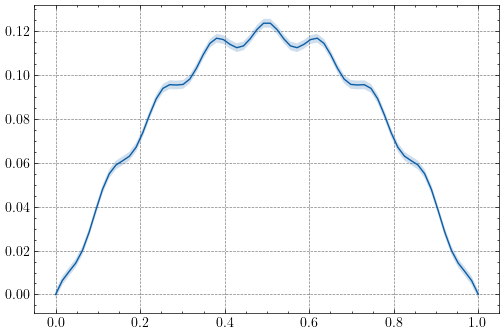

In [126]:
fig, axes = plt.subplots(figsize=(6,4))
axes.plot(true_coordinates,u_strue[-1,:])
axes.fill_between(true_coordinates.flatten(), u_strue[-1,:]-2*sigma_n_true, u_strue[-1,:]+2*sigma_n_true, alpha=0.2)

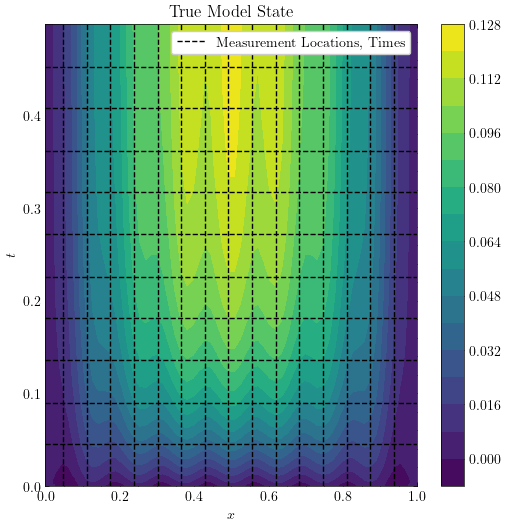

In [127]:
fig, axes = plt.subplots(figsize=(6,6))
plot = axes.contourf(true_coordinates.flatten(), time_range, u_strue, levels=contour_levels)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Locations, Times', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black')
    else:
        axes.axhline(coord, linestyle='--', color='black')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

#axes.scatter(x_temp, y_temp, marker='x', label='Observed Points', color='black')
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
axes.set_title('True Model State')
fig.colorbar(plot)
plt.legend()
plt.show()

In [128]:
number_of_x_axial_cells = 64

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

t_start = 0
dt = 0.001
t_end = 0.5
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

u_0 = np.zeros(n_x)
u_s = np.zeros((number_of_steps, n_x))
u_s[0,:] = u_0

covs = [np.zeros((n_x,n_x))]

observation_operator = np.zeros((len(spatial_measurement_coordinates), len(coordinates)))
for i, y in enumerate(spatial_measurement_coordinates):
    nearest_index = np.argmin(np.abs(coordinates - y))
    observation_operator[i, nearest_index] = 1

def mark_times(all_time, mark_time):
    time_operator = np.zeros_like(all_time, dtype=bool)

    # Find the closest point in X for each element in Y
    for time in mark_time:
        closest_index = np.argmin(np.abs(all_time - time))
        time_operator[closest_index] = True
    return time_operator

time_operator = mark_times(time_range, temporal_measurement_coordinates)

In [129]:
@fem.BilinearForm
def M_form(u,v,w):
    return u*v

@fem.BilinearForm
def A_form(u,v,w):
    return dot(grad(u),grad(v))

@fem.LinearForm
def L_form(v,w):
    return 1. * v

K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)
K_theta_3 = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)
K_theta_3_np = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)

A_mat = (A_form.assemble(basis)).toarray()
L_vec = L_form.assemble(basis)
M_mat = (M_form.assemble(basis)).toarray()

def left_side(alpha):
    left_mat = (M_mat + (dt*alpha/2)*A_mat)
    left_mat = subtensor.set_subtensor(left_mat[0,:], 0.)
    left_mat = subtensor.set_subtensor(left_mat[-1,:], 0.)
    left_mat = subtensor.set_subtensor(left_mat[0,0], 1.)
    left_mat = subtensor.set_subtensor(left_mat[-1,-1], 1.)
    # left_mat[boundary_indices,:] = left_mat[:,boundary_indices] = 0.
    # left_mat[boundary_indices, boundary_indices] = 1.
    return left_mat

def left_side_np(alpha):
    left_mat = (M_mat + (dt*alpha/2)*A_mat)
    # left_mat = subtensor.set_subtensor(left_mat[0,:], 0.)
    # left_mat = subtensor.set_subtensor(left_mat[-1,:], 0.)
    # left_mat = subtensor.set_subtensor(left_mat[0,0], 1.)
    # left_mat = subtensor.set_subtensor(left_mat[-1,-1], 1.)
    left_mat[boundary_indices,:] = left_mat[:,boundary_indices] = 0.
    left_mat[boundary_indices, boundary_indices] = 1.
    return left_mat

def right_side(alpha, beta, u_prev):
    right_mat = (M_mat - (dt*alpha/2)*A_mat) @ u_prev + dt*beta*L_vec
    right_mat = subtensor.set_subtensor(right_mat[0], 0.)
    right_mat = subtensor.set_subtensor(right_mat[-1], 0.)
    return right_mat

def G_theta_mat(rho, ell):
    G_vec = (rho**2)*tensor.math.exp(K_theta_3/(2*(ell**2)))
    return tensor.reshape(G_vec, (n_x, n_x))

def G_theta_mat_np(rho, ell):
    G_vec = (rho**2)*np.exp(K_theta_3_np/(2*(ell**2)))
    return np.reshape(G_vec, (n_x, n_x))


In [130]:
# PRIORS ------------
# alpha
lower = 0.0001
upper = 3.
mu = 0.5
sigma = 0.5
alpha_params = [lower, upper, mu, sigma]

# beta
lower = 0.0001
upper = 3.
mu = 1.5
sigma = 0.5
beta_params = [lower, upper, mu, sigma]

# rho
lower = 0.0001
upper = 1.
mu = 0.1
sigma = 0.1
rho_params = [lower, upper, mu, sigma]

# ell
lower = 0.0001
upper = 3.
mu = 0.1
sigma = 0.1
ell_params = [lower, upper, mu, sigma]

# sigma_n
lower = 0.0001
upper = 1.
mu = 0.005
sigma = 0.005
sigma_n_params = [lower, upper, mu, sigma]

# --------------

In [131]:
alpha = alpha_params[2]
beta = beta_params[2]
rho = rho_params[2]
ell = ell_params[2]
sigma_n = sigma_n_params[2]

traces = [] # box of traces
priors = [] # box of kdes

data_index = 0 # index of observation vector

for i, t in tqdm(enumerate(time_range[:-1])):
    if i == 0: # if its the first step, we initialise mean based off initial condition, and initialise cov matrix
        right_hand_side = (M_mat - (dt*alpha/2)*A_mat) @ u_s[i,:] + dt*beta*L_vec
        right_hand_side[0] = right_hand_side[-1] = 0.
        pred_mean = np.linalg.inv(left_side_np(alpha)) @ right_hand_side
        pred_cov = dt*np.linalg.inv(left_side_np(alpha)) @ M_mat @ G_theta_mat_np(rho, ell) @ M_mat.T @ np.linalg.inv(left_side_np(alpha)).T
        u_s[i+1, :] = pred_mean
        covs.append(pred_cov)
    else: # if it isnt the first step,
        if time_operator[i] == False: # and we dont have data for the current step, update as usual, but since cov matrix isnt evolving we can just duplicate it
            right_hand_side = (M_mat - (dt*alpha/2)*A_mat) @ u_s[i,:] + dt*beta*L_vec
            right_hand_side[0] = right_hand_side[-1] = 0.
            pred_mean = np.linalg.inv(left_side_np(alpha)) @ right_hand_side
            pred_cov = (np.linalg.inv(left_side_np(alpha)) @ (M_mat - (dt*alpha/2)*A_mat)) @ covs[-1] @ (np.linalg.inv(left_side_np(alpha)) @ (M_mat - (dt*alpha/2)*A_mat)).T + dt*np.linalg.inv(left_side_np(alpha)) @ M_mat @ G_theta_mat_np(rho, ell) @ M_mat.T @ np.linalg.inv(left_side_np(alpha)).T
            u_s[i+1,:] = pred_mean
            covs.append(pred_cov)
        else: # and we do have data, we MCMC step
            with pm.Model() as model:
                if data_index == 0: # if its the first time that data has come in, we use the initial trunc norm priors
                    alpha = pm.TruncatedNormal('alpha', mu=alpha_params[3], sigma=alpha_params[2], lower=alpha_params[0], upper=alpha_params[1])
                    beta = pm.TruncatedNormal('beta', mu=beta_params[3], sigma=beta_params[2], lower=beta_params[0], upper=beta_params[1])
                    rho = pm.TruncatedNormal('rho', mu=rho_params[3], sigma=rho_params[2], lower=rho_params[0], upper=rho_params[1])
                    ell = pm.TruncatedNormal('ell', mu=ell_params[3], sigma=ell_params[2], lower=ell_params[0], upper=ell_params[1])
                    sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[3], sigma=sigma_n_params[2], lower=sigma_n_params[0], upper=sigma_n_params[1])
                else: # otherwise, we use a kde estimate from previous trace
                    alpha = pm.TruncatedNormal('alpha', mu=alpha, sigma=alpha_std, lower=alpha_params[0], upper=alpha_params[1])
                    beta = pm.TruncatedNormal('beta', mu=beta, sigma=beta_std, lower=beta_params[0], upper=beta_params[1])
                    rho = pm.TruncatedNormal('rho', mu=rho, sigma=rho_std, lower=rho_params[0], upper=rho_params[1])
                    ell = pm.TruncatedNormal('ell', mu=ell, sigma=ell_std, lower=ell_params[0], upper=ell_params[1])
                    sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n, sigma=sigma_n_std, lower=sigma_n_params[0], upper=sigma_n_params[1])
                
                left_side_matrix = pm.Deterministic('left_side', left_side(alpha))
                G_rho_ell = pm.Deterministic('G_rho_ell', M_mat @ G_theta_mat(rho, ell) @ M_mat.T)

                left_side_inv = tensor.nlinalg.matrix_inverse(left_side_matrix)
                right_side_vector = pm.Deterministic('right_side', right_side(alpha, beta, u_s[i,:]))
                mu_u = pm.Deterministic('mu_u', left_side_inv @ right_side_vector)
                cov_u = pm.Deterministic('cov_u', (left_side_inv @ (M_mat - (dt*alpha/2)*A_mat)) @ covs[-1] @ (left_side_inv @ (M_mat - (dt*alpha/2)*A_mat)).T + dt*left_side_inv@ G_rho_ell @ left_side_inv.T)

                cov_chol = tensor.linalg.cholesky(observation_operator @ cov_u @ observation_operator.T + sigma_n**2 * np.eye(spatial_points))
                y_obs = pm.MvNormal('y_obs', mu = observation_operator @ mu_u, chol = cov_chol, observed=u_observed[data_index,:])
                trace = pm.sample(nuts_sampler="numpyro", chains=2, target_accept=0.95)
                traces.append(trace)
            
            # update parameters to means of their posteriors
            alpha = np.mean(traces[-1].posterior['alpha'].data.flatten())
            alpha_std = np.std(traces[-1].posterior['alpha'].data.flatten())
            beta = np.mean(traces[-1].posterior['beta'].data.flatten())
            beta_std = np.std(traces[-1].posterior['beta'].data.flatten())
            rho = np.mean(traces[-1].posterior['rho'].data.flatten())
            rho_std = np.std(traces[-1].posterior['rho'].data.flatten())
            ell = np.mean(traces[-1].posterior['ell'].data.flatten())
            ell_std = np.std(traces[-1].posterior['ell'].data.flatten())
            sigma_n = np.mean(traces[-1].posterior['sigma_n'].data.flatten())
            sigma_n_std = np.std(traces[-1].posterior['sigma_n'].data.flatten())

            # compute mean and covariance based off of estimated parameters, and
            right_hand_side = (M_mat - (dt*alpha/2)*A_mat) @ u_s[i,:] + dt*beta*L_vec
            right_hand_side[0] = right_hand_side[-1] = 0.
            pred_mean = np.linalg.inv(left_side_np(alpha)) @ right_hand_side
            pred_cov = (np.linalg.inv(left_side_np(alpha)) @ (M_mat - (dt*alpha/2)*A_mat)) @ covs[-1] @ (np.linalg.inv(left_side_np(alpha)) @ (M_mat - (dt*alpha/2)*A_mat)).T + dt*np.linalg.inv(left_side_np(alpha)) @ M_mat @ G_theta_mat_np(rho, ell) @ M_mat.T @ np.linalg.inv(left_side_np(alpha)).T
            updated_mean = pred_mean + pred_cov @ observation_operator.T @ np.linalg.inv(observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2)*np.eye(spatial_points)) @ (u_observed[data_index] - observation_operator @ pred_mean)
            updated_cov = pred_cov - pred_cov @ observation_operator.T @ np.linalg.inv(observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2)*np.eye(spatial_points)) @ observation_operator @ pred_cov
            u_s[i+1,:] = updated_mean
            covs.append(updated_cov)
            data_index += 1


cov_diags = np.zeros((number_of_steps, number_of_x_axial_cells))
for i in range(number_of_steps-1):
    cov_diags[i,:] = np.diag(covs[i])

0it [00:00, ?it/s]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
We recommend running at least 4 chains for robust computation of convergence diagnostics
46it [00:49,  1.07s/it]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
We recommend running at least 4 chains for robust computation of convergence diagnostics
91it [01:41,  1.12s/it]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
We recommend running at least

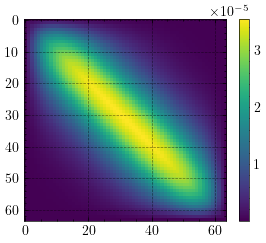

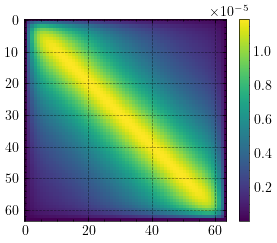

In [163]:
plt.imshow(np.linalg.inv(left_side_np(alpha)) @ (M_mat - (dt*alpha/2)*A_mat) @ covs[40] @ (np.linalg.inv(left_side_np(alpha)) @ (M_mat - (dt*alpha/2)*A_mat)).T)
plt.colorbar()
plt.show()

plt.imshow(dt*np.linalg.inv(left_side_np(alpha)) @ M_mat @ G_theta_mat_np(rho, ell) @ M_mat.T @ np.linalg.inv(left_side_np(alpha)).T)
plt.colorbar()
plt.show()

In [132]:
temporal_measurement_indices

array([ 45,  90, 136, 181, 226, 272, 317, 362, 408, 453])

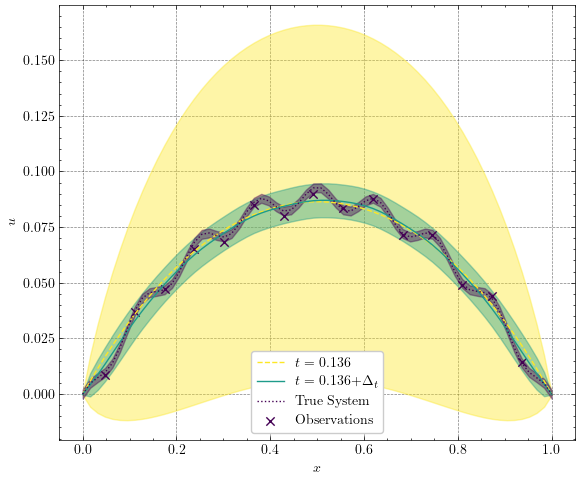

In [142]:
interest = 2
time_labels = [r"$t=$ "+str(temporal_measurement_coordinates[i]) for i in range(len(temporal_measurement_coordinates))]
plot_ind = temporal_measurement_indices[interest]

fig, axes = plt.subplots(figsize=(6,5))

axes.plot(coordinates,u_s[plot_ind,:], label=time_labels[interest], color=color_list[0], linestyle='dashed')
axes.fill_between(coordinates.flatten(), u_s[plot_ind,:] - 2*np.sqrt(cov_diags[plot_ind]), u_s[plot_ind,:] + 2*np.sqrt(cov_diags[plot_ind]), alpha=0.4, color=color_list[0])

axes.plot(coordinates,u_s[plot_ind + 1,:], label=time_labels[interest] + r'$+ \Delta_t$', color=color_list[5])
axes.fill_between(coordinates.flatten(), u_s[plot_ind+1,:] - 2*np.sqrt(cov_diags[plot_ind+1]), u_s[plot_ind+1,:] + 2*np.sqrt(cov_diags[plot_ind+1]), alpha=0.4, color=color_list[5])

axes.plot(true_coordinates, u_strue[plot_ind+1,:], label='True System', color=color_list[11], linestyle='dotted')
axes.scatter(spatial_measurement_coordinates, u_observed[interest,:], label='Observations', marker='x', color=color_list[11])
axes.fill_between(true_coordinates.flatten(), u_strue[plot_ind+1,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[plot_ind+1,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.4, color=color_list[11])

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$u$')

axes.legend(loc='lower center')
fig.tight_layout()
plt.show()

In [134]:
temporal_measurement_indices

array([ 45,  90, 136, 181, 226, 272, 317, 362, 408, 453])

In [135]:
for time_index in tqdm(range(len(time_range))):
    filename = r"video_pics/image" + str(time_index) + ".png"
    time_labels = [r"$t=$ "+str(time_range[i]) for i in range(len(time_range))]

    fig, axes = plt.subplots(figsize=(6,5))

    axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[0])
    axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(cov_diags[time_index]), u_s[time_index,:] + 2*np.sqrt(cov_diags[time_index]), alpha=0.4, color=color_list[0])

    axes.plot(true_coordinates, u_strue[time_index,:], label='True System', color=color_list[11], linestyle='dotted')
    axes.fill_between(true_coordinates.flatten(), u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.4, color=color_list[11])

    axes.set_xlabel(r'$x$')
    axes.set_ylabel(r'$u$')

    axes.set_ylim(-0.02, 0.14)

    axes.legend(loc='lower center')
    fig.tight_layout()
    plt.savefig(filename)
    plt.close()

100%|██████████| 500/500 [02:26<00:00,  3.40it/s]


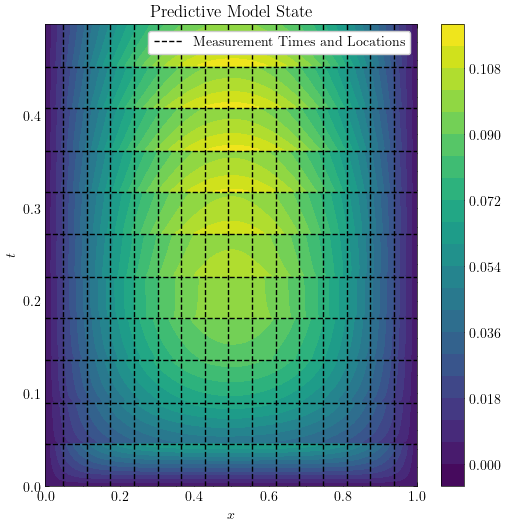

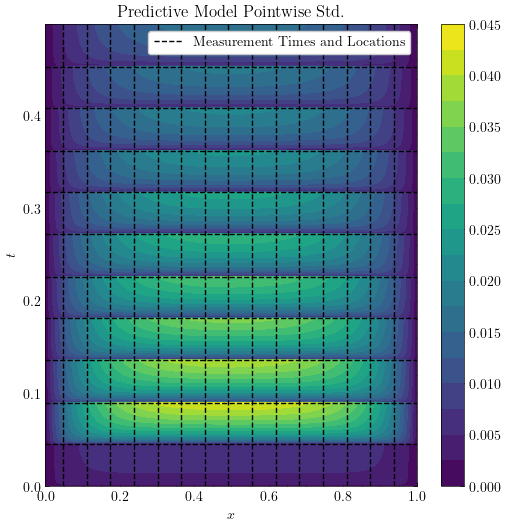

In [136]:
fig, axes = plt.subplots(figsize=(6,6))
plot = axes.contourf(coordinates.flatten(), time_range, u_s, levels=contour_levels)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Times and Locations', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black')
    else:
        axes.axhline(coord, linestyle='--', color='black')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
axes.set_title('Predictive Model State')
fig.colorbar(plot)
plt.legend()
plt.show()

fig, axes = plt.subplots(figsize=(6,6))
plot = axes.contourf(coordinates.flatten(), time_range, np.sqrt(cov_diags), levels=contour_levels)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Times and Locations', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black')
    else:
        axes.axhline(coord, linestyle='--', color='black')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
axes.set_title('Predictive Model Pointwise Std.')
fig.colorbar(plot)
plt.legend()
plt.show()

/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

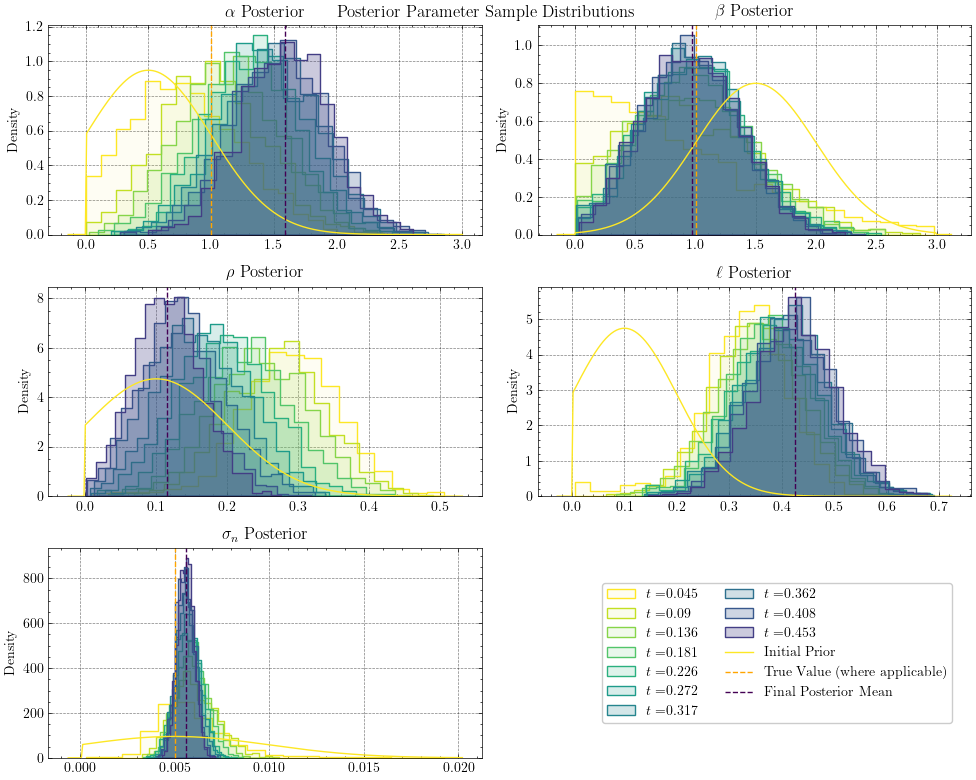

In [137]:
group_labels = [r"$t= $"+str(round(temporal_measurement_coordinates[i],3)) for i in range(len(temporal_measurement_coordinates))]

# Plotting histograms
plt.figure(figsize=(10, 8))

bins_num = 20

plt.subplot(3, 2, 1)
group = 1
alpha_val = 0.05
col_index = 0
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['alpha'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    else:
        sns.histplot(trace.posterior['alpha'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    alpha_val += 0.025
    col_index += 1
    group += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (alpha_params[0] - alpha_params[2]) / alpha_params[3], (alpha_params[1] - alpha_params[2]) / alpha_params[3]
truncated_normal = truncnorm(a, b, loc=alpha_params[2], scale=alpha_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior', color=color_list[0])
plt.axvline(true_alpha, color='orange', label='True Value', linestyle='--')
plt.axvline(alpha, label='Final Posterior Mean', linestyle='--', color=color_list[-1])
#plt.legend()
ax.set_title(r'$\alpha$ Posterior')

plt.subplot(3, 2, 2)
group = 1
alpha_val = 0.05
col_index = 0
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['beta'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    else:
        sns.histplot(trace.posterior['beta'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    group += 1
    alpha_val += 0.025
    col_index += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (beta_params[0] - beta_params[2]) / beta_params[3], (beta_params[1] - beta_params[2]) / beta_params[3]
truncated_normal = truncnorm(a, b, loc=beta_params[2], scale=beta_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior', color=color_list[0])
plt.axvline(true_beta, color='orange', label='True Value', linestyle='--')
plt.axvline(beta, label='Final Posterior Mean', linestyle='--', color=color_list[-1])
#plt.legend()
ax.set_title(r'$\beta$ Posterior')

plt.subplot(3, 2, 3)
group = 1
alpha_val = 0.05
col_index = 0
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['rho'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    else:
        sns.histplot(trace.posterior['rho'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    group += 1
    alpha_val += 0.025
    col_index += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (rho_params[0] - rho_params[2]) / rho_params[3], (rho_params[1] - rho_params[2]) / rho_params[3]
truncated_normal = truncnorm(a, b, loc=rho_params[2], scale=rho_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior', color=color_list[0])
plt.axvline(rho, label='Final Posterior Mean', linestyle='--', color=color_list[-1])
#plt.legend()
ax.set_title(r'$\rho$ Posterior')

plt.subplot(3, 2, 4)
group = 1
alpha_val = 0.05
col_index = 0
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['ell'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    else:
        sns.histplot(trace.posterior['ell'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    group += 1
    alpha_val += 0.025
    col_index += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (ell_params[0] - ell_params[2]) / ell_params[3], (ell_params[1] - ell_params[2]) / ell_params[3]
truncated_normal = truncnorm(a, b, loc=ell_params[2], scale=ell_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior', color=color_list[0])
plt.axvline(ell, label='Final Posterior Mean', linestyle='--', color=color_list[-1])
#plt.legend()
ax.set_title(r'$\ell$ Posterior')

plt.subplot(3, 2, 5)
group = 1
alpha_val = 0.05
col_index = 0
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['sigma_n'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    else:
        sns.histplot(trace.posterior['sigma_n'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val, color=color_list[col_index])
    group += 1
    alpha_val += 0.025
    col_index += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (sigma_n_params[0] - sigma_n_params[2]) / sigma_n_params[3], (sigma_n_params[1] - sigma_n_params[2]) / sigma_n_params[3]
truncated_normal = truncnorm(a, b, loc=sigma_n_params[2], scale=sigma_n_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior', color=color_list[0])
plt.axvline(0.005, color='orange', label='True Value (where applicable)', linestyle='--')
plt.axvline(sigma_n, label='Final Posterior Mean', linestyle='--', color=color_list[-1])
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.52, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(2.1, 0.5),fancybox=True,ncols=2)
ax.set_title(r'$\sigma_n$ Posterior')

plt.tight_layout()
plt.suptitle('Posterior Parameter Sample Distributions')
plt.show()


In [138]:
alpha_estimates = [np.mean(traces[i].posterior['alpha'].data.flatten()) for i in range(len(traces))]
beta_estimates = [np.mean(traces[i].posterior['beta'].data.flatten()) for i in range(len(traces))]
rho_estimates = [np.mean(traces[i].posterior['rho'].data.flatten()) for i in range(len(traces))]
ell_estimates = [np.mean(traces[i].posterior['ell'].data.flatten()) for i in range(len(traces))]
sigma_n_estimates = [np.mean(traces[i].posterior['sigma_n'].data.flatten()) for i in range(len(traces))]
rms = np.sqrt(np.mean((u_s - u_strue)**2, axis=1))
plot_time_coords = temporal_measurement_coordinates

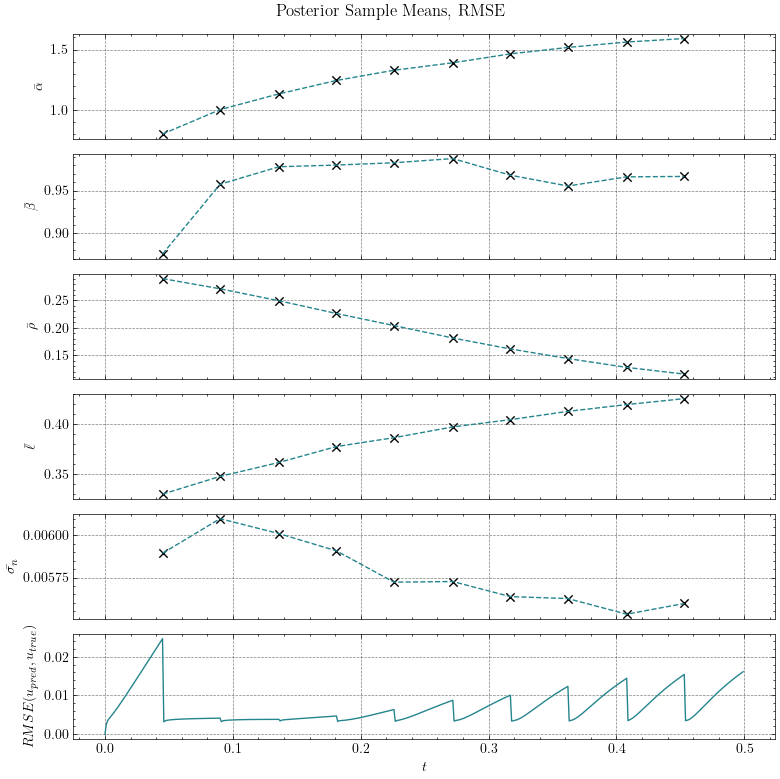

In [139]:
fig, axs = plt.subplots(6, 1, figsize=(8, 8), sharex=True)

# Scatter plots for the first five estimates
axs[0].plot(plot_time_coords, alpha_estimates, label='Alpha Estimates', color=color_list[6], linestyle='dashed')
axs[0].scatter(plot_time_coords, alpha_estimates, marker='x', color='black')
#axs[0].set_ylim((alpha_params[0],alpha_params[1]))
axs[0].set_ylabel(r'$\bar{\alpha}$')

axs[1].plot(plot_time_coords, beta_estimates, label='Beta Estimates', color=color_list[6], linestyle='dashed')
axs[1].scatter(plot_time_coords, beta_estimates, marker='x', color='black')
#axs[1].set_ylim((beta_params[0],beta_params[1]))
axs[1].set_ylabel(r'$\bar{\beta}$')

axs[2].plot(plot_time_coords, rho_estimates, label='Rho Estimates', color=color_list[6], linestyle='dashed')
axs[2].scatter(plot_time_coords, rho_estimates, marker='x', color='black')
axs[2].set_ylabel(r'$\bar{\rho}$')

axs[3].plot(plot_time_coords, ell_estimates, label='Ell Estimates', color=color_list[6], linestyle='dashed')
axs[3].scatter(plot_time_coords, ell_estimates, marker='x', color='black')
axs[3].set_ylabel(r'$\bar{\ell}$')

axs[4].plot(plot_time_coords, sigma_n_estimates, label='Sigma_n Estimates', color=color_list[6], linestyle='dashed')
axs[4].scatter(plot_time_coords, sigma_n_estimates, marker='x', color='black')
axs[4].set_ylabel(r'$\bar{\sigma_n}$')

axs[5].plot(time_range, rms, label='RMS Error', color=color_list[6])
axs[5].set_ylabel(r'$RMSE(u_{pred}, u_{true})$')
axs[5].set_xlabel(r'$t$')

fig.suptitle('Posterior Sample Means, RMSE')
fig.tight_layout()
# Adjust layout
#plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

In [231]:
az.summary(traces[-1], var_names=["alpha", "beta","rho","ell","sigma_n"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.179,0.401,0.390,1.897,0.011,0.008,1373.0,776.0,1.0
beta,0.956,0.344,0.297,1.576,0.008,0.006,1720.0,712.0,1.0
rho,0.194,0.065,0.071,0.318,0.001,0.001,2091.0,803.0,1.0
ell,0.210,0.071,0.076,0.337,0.002,0.002,1103.0,507.0,1.0
sigma_n,0.010,0.001,0.008,0.012,0.000,0.000,2066.0,1552.0,1.0
